In [1]:
# NOTE: PLEASE MAKE SURE YOU ARE RUNNING THIS IN A PYTHON3 ENVIRONMENT

import tensorflow as tf
print(tf.__version__)


1.15.0


In [33]:
# Uncomment and run this if you don't have TensorFlow 2.0x [Check for latest 2.0 instructions at https://www.tensorflow.org/versions/r2.0/api_docs/python/tf]
!pip install tensorflow==2.0.0-beta0

  Using cached https://files.pythonhosted.org/packages/6c/19/0d0c7f240db7bcd6b83783b9a89a67f38584d100e23ad5ae93114be92232/tensorflow-2.0.0b0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a4/96/571b875cd81dda9d5dfa1422a4f9d749e67c0a8d4f4f0b33a4e5f5f35e27/tb_nightly-1.14.0a20190603-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/32/dd/99c47dd007dcf10d63fd895611b063732646f23059c618a373e85019eb0e/tf_estimator_nightly-1.14.0.dev2019060501-py2.py3-none-any.whl
  Found existing installation: tb-nightly 1.15.0a20190806
    Uninstalling tb-nightly-1.15.0a20190806:
      Successfully uninstalled tb-nightly-1.15.0a20190806
  Found existing installation: tf-estimator-nightly 1.14.0.dev2019080601
    Uninstalling tf-estimator-nightly-1.14.0.dev2019080601:
      Successfully uninstalled tf-estimator-nightly-1.14.0.dev2019080601
  Found existing installation: tensorflow 2.0.0rc0
    Uninstalling tensorflow-2.0.0rc0:
      Successfully 

In [2]:
# Double check TF 2.0x is installed. If you ran the above block, there was a 
# 'reset all runtimes' button at the bottom that you needed to press
import tensorflow as tf
print(tf.__version__)

2.0.0-beta0


In [0]:
# If the import fails, run this
#!pip install -q tensorflow-datasets

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)


In [0]:
train_data, test_data = imdb['train'], imdb['test']

In [6]:
print(test_data)

<_OptionsDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>


In [0]:
tokenizer = info.features['text'].encoder

у нас есть предварительно обученный токенайзер подслов, поэтому мы можем проверить его словарь, посмотрев на его свойство `subwords`. 

In [8]:
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

Посмотрите, словарь довольно короткий. Это связано с тем, что вариантов разных фрагментов слов гораздо меньше, чем самих слов. А букв - вообще всего несколько десятков. 

***Разбиение слов на подслова - хороший способ сделать компактный универсальный словарь, и так же попытка некоторого разбора слов по составу, что необходимо в случае с таким языком как русский, с его приставками суффиксами и окончаниями.***

In [9]:
print(len(tokenizer.subwords))

7928


Если мы хотим увидеть, как он кодирует или декодирует строки, мы можем сделать это с помощью этого кода:

In [10]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))


Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [11]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


Теперь давайте посмотрим на классификацию IMDB с фрагментами слов. 
Эта  модель выглядит очень знакомо, однако следует принять во внимание форму векторов, идущих от токенайзера через embedding, и их нелегко "расплющить", как мы это делали раньше. Так что вместо этого мы будем использовать GlobalAveragePooling1D. Попытка использовать `Flatten` приведет к падению TensorFlow.

In [12]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


Обучение здесь работает с большим количеством гиперпараметров и подслов, поэтому имейте в виду, оно будет медленным. Запуск на Colab с GPU занял у меня около четырех с половиной минут на эпоху.

In [13]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_data, epochs=num_epochs, validation_data=test_data)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


25000/25000 [==============================] - 456s 18ms/step - loss: 0.6851 - accuracy: 0.5372 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
25000/25000 [==============================] - 236s 9ms/step - loss: 0.6832 - accuracy: 0.5415 - val_loss: 0.6841 - val_accuracy: 0.5382
Epoch 3/10
25000/25000 [==============================] - 237s 9ms/step - loss: 0.6826 - accuracy: 0.5432 - val_loss: 0.6840 - val_accuracy: 0.5392
Epoch 4/10
25000/25000 [==============================] - 238s 10ms/step - loss: 0.6822 - accuracy: 0.5443 - val_loss: 0.6840 - val_accuracy: 0.5397
Epoch 5/10
25000/25000 [==============================] - 236s 9ms/step - loss: 0.6819 - accuracy: 0.5454 - val_loss: 0.6841 - val_accuracy: 0.5400
Epoch 6/10
25000/25000 [==============================] - 235s 9ms/step - loss: 0.6816 - accuracy: 0.5460 - val_loss: 0.6842 - val_accuracy: 0.5401
Epoch 7/10
25000/25000 [==============================] - 235s 9ms/step - loss: 0.6814 - accuracy: 0.5466 - val_l

Если ваши результаты не выглядят хорошими, не волнуйтесь, так и должно было случиться.

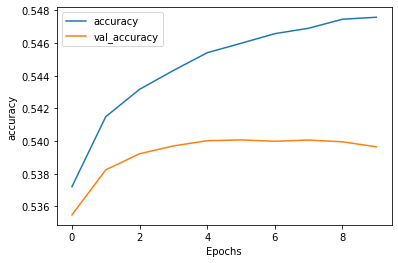

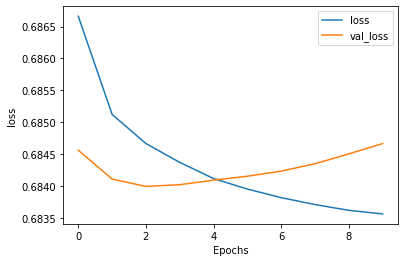

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Почему же, по-вашему мнению, всё так плохо? 
Попробуйте ответить самостоятельно.

Дело в том, что мы используем подслова, а многие подслова часто не имеют смысла сами по себе, и только если стоят в какой-то последовательности, имеют значимую семантику. 

Таким образом, обучение на последовательностях подслов будет отличным шагом вперед, и это именно то, что вы узнаете в следующей лекции "Нейронныме сети последовательностей".

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')